In [1]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

import random
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import MinMaxScaler

In [31]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_PATH = "./../../datasets/Polyvore"
BATCH_SIZE = 64
OPT_LR = 1e-2
MAX_EPOCHS = 50

In [ ]:
EMB_MODEL = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
EMB_PROCESSOR = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [3]:
def embed_image(image_path):
    img = Image.open(image_path).convert("RGB")
    inputs = EMB_PROCESSOR(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        emb = EMB_MODEL.get_image_features(**inputs)
    emb = emb.cpu().numpy()
    emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    return emb[0]

In [4]:
def read_json_file(path):
    with open(path) as json_file:
        data = json.load(json_file)
        return data

In [5]:
categories_df = pd.read_csv(f"{DATASET_PATH}/polyvore/categories.csv", header=None)


categories_dict = {}
for i, row in categories_df.iterrows():
    if row[1] in ("pants", "shirt"):
        categories_dict[row[0]] = row[1]


orig_data = read_json_file(f"{DATASET_PATH}/polyvore/train_no_dup.json")

final_data = {}
for set_data in tqdm(orig_data):
    tmp_items = {}
    for item_data in set_data["items"]:
        if item_data["categoryid"] in categories_dict:
            cat_name = categories_dict[item_data["categoryid"]]

            tmp_items[cat_name] = {
                "index": item_data["index"],
                "price": item_data["price"],
                "likes": item_data["likes"],
                "image": item_data["image"],
                "categoryid": item_data["categoryid"],
                "categoryname": cat_name,
                "path": f"{DATASET_PATH}/maryland-polyvore-images-1/maryland-polyvore-images/versions/1/images/{set_data['set_id']}/{item_data['index']}.jpg",
            }
            tmp_items[cat_name]["embedding"] = embed_image(tmp_items[cat_name]["path"])
    if len(tmp_items) == 2:
        final_data[set_data["set_id"]] = {
            "set_id": set_data["set_id"],
            "likes": set_data["likes"],
            "items": tmp_items
        }

100%|██████████| 17316/17316 [01:09<00:00, 248.82it/s]


In [6]:
final_data = list(final_data.values())
random.shuffle(final_data)
train_data, test_data = final_data[:-100], final_data[-100:]

In [7]:
likes = []
for set_data in train_data:
    likes.append(set_data["likes"])
    likes.append(set_data["items"]["shirt"]["likes"])
    likes.append(set_data["items"]["pants"]["likes"])

scaler = MinMaxScaler()
scaler.fit(np.array(likes).reshape(-1, 1))

for set_data in train_data:
    set_data["likes"] = scaler.transform(np.array([set_data["likes"]]).reshape(1, -1))
    set_data["items"]["shirt"]["likes"] = scaler.transform(np.array([set_data["items"]["shirt"]["likes"]]).reshape(1, -1))
    set_data["items"]["pants"]["likes"] = scaler.transform(np.array([set_data["items"]["pants"]["likes"]]).reshape(1, -1))

for set_data in test_data:
    set_data["likes"] = scaler.transform(np.array([set_data["likes"]]).reshape(1, -1))
    set_data["items"]["shirt"]["likes"] = scaler.transform(np.array([set_data["items"]["shirt"]["likes"]]).reshape(1, -1))
    set_data["items"]["pants"]["likes"] = scaler.transform(np.array([set_data["items"]["pants"]["likes"]]).reshape(1, -1))


In [8]:
train_data[0]

{'set_id': '189698226',
 'likes': array([[0.00116053]]),
 'items': {'shirt': {'index': 1,
   'price': 16.0,
   'likes': array([[0.16517248]]),
   'image': 'http://img1.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=160018062',
   'categoryid': 11,
   'categoryname': 'shirt',
   'path': './../../datasets/Polyvore/maryland-polyvore-images-1/maryland-polyvore-images/versions/1/images/189698226/1.jpg',
   'embedding': array([ 1.09684933e-02,  3.43733584e-03,  1.39176184e-02,  3.78050059e-02,
          -2.69691870e-02,  2.72604022e-02, -7.49447569e-03,  5.74196950e-02,
           2.53442172e-02,  4.74725328e-02, -1.92955055e-03,  3.44332606e-02,
           3.25014107e-02, -7.35757574e-02, -8.29650275e-03,  3.77753079e-02,
           2.06383131e-02, -1.23326881e-02, -4.41181250e-02,  1.08618289e-02,
           3.07518709e-03, -3.57588567e-02,  2.75743252e-04, -4.18792330e-02,
           4.16680835e-02,  1.72793176e-02, -7.54790893e-03, -1.10004935e-02,
           3.66819580e-03,  8.540948

In [26]:
class CompatibilityDataset(Dataset):
    def __init__(self, _data):
        super().__init__()
        self.data = _data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        d = self.data[idx]

        set_likes = torch.tensor(d["likes"].squeeze(), dtype=torch.float32).unsqueeze(0)

        shirt_path = d["items"]["shirt"]["path"]
        shirt_likes = torch.tensor(d["items"]["shirt"]["likes"].squeeze(), dtype=torch.float32).unsqueeze(0)
        shirt_embed = torch.tensor(d["items"]["shirt"]["embedding"], dtype=torch.float32)

        pants_path = d["items"]["pants"]["path"]
        pants_likes = torch.tensor(d["items"]["pants"]["likes"].squeeze(), dtype=torch.float32).unsqueeze(0)
        pants_embed = torch.tensor(d["items"]["pants"]["embedding"], dtype=torch.float32)

        return set_likes, shirt_path, shirt_likes, shirt_embed, pants_path, pants_likes, pants_embed

In [27]:
train_dl = DataLoader(CompatibilityDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dl = DataLoader(CompatibilityDataset(test_data), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [28]:
class CompatibilityModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.set_fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.BatchNorm1d(num_features=512),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(in_features=512, out_features=64),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(in_features=64, out_features=1)
        )

        self.shirt_fc = nn.Sequential(
            nn.Linear(in_features=512, out_features=64),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(in_features=64, out_features=1)
        )

        self.pants_fc = nn.Sequential(
            nn.Linear(in_features=512, out_features=64),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, shirt_embed, pants_embed):

        set_embed = torch.cat((shirt_embed, pants_embed), dim=1)

        set_logits = self.set_fc(set_embed)

        shirt_logits = self.shirt_fc(shirt_embed)

        pants_logits = self.pants_fc(pants_embed)

        return set_logits, shirt_logits, pants_logits


In [29]:
def save_checkpoint(_path, _epoch, _model, _optimizer, _prev_loss, _current_loss):
    sd = {
        "epoch": _epoch,
        "model_state_dict": _model.state_dict(),
        "optimizer_state_dict": _optimizer.state_dict(),
    }

    torch.save(sd, os.path.join(_path, "last.pt"))

    if _prev_loss > _current_loss:
        torch.save(sd, os.path.join(_path, "best.pt"))

In [32]:
current_loss = np.inf
prev_loss = current_loss

model = CompatibilityModel()
optimizer = torch.optim.SGD(model.parameters(), lr=OPT_LR)

model = model.to(DEVICE)

for ep in range(1, MAX_EPOCHS + 1):
    TOTAL_LOSSES = []
    SET_LOSSES = []
    SHIRT_LOSSES = []
    PANTS_LOSSES = []
    model.train()
    prev_loss = current_loss
    t = tqdm(train_dl)
    for bn, (set_likes, _, shirt_likes, shirt_embed, _, pants_likes, pants_embed) in enumerate(t):

        set_likes = set_likes.to(DEVICE)
        shirt_embed = shirt_embed.to(DEVICE)
        shirt_likes = shirt_likes.to(DEVICE)
        pants_embed = pants_embed.to(DEVICE)
        pants_likes = pants_likes.to(DEVICE)

        set_logits, shirt_logits, pants_logits = model(shirt_embed, pants_embed)

        loss_set = F.binary_cross_entropy_with_logits(set_logits, set_likes)
        loss_shirt = F.binary_cross_entropy_with_logits(shirt_logits, shirt_likes)
        loss_pants = F.binary_cross_entropy_with_logits(pants_logits, pants_likes)

        loss = loss_set + loss_shirt + loss_pants

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        TOTAL_LOSSES.append(loss.item())
        SET_LOSSES.append(loss_set.item())
        SHIRT_LOSSES.append(loss_shirt.item())
        PANTS_LOSSES.append(loss_pants.item())

        t.set_description_str(f"Train ep{ep} | TL: {np.mean(TOTAL_LOSSES):.3f} | SL: {np.mean(SET_LOSSES):0.3f} | SHL: {np.mean(SHIRT_LOSSES):0.3f} | PL: {np.mean(PANTS_LOSSES):0.3f}")

    TOTAL_LOSSES = []
    SET_LOSSES = []
    SHIRT_LOSSES = []
    PANTS_LOSSES = []
    model.eval()
    t = tqdm(test_dl)
    for bn, (set_likes, _, shirt_likes, shirt_embed, _, pants_likes, pants_embed) in enumerate(t):
        set_likes = set_likes.to(DEVICE)
        shirt_embed = shirt_embed.to(DEVICE)
        shirt_likes = shirt_likes.to(DEVICE)
        pants_embed = pants_embed.to(DEVICE)
        pants_likes = pants_likes.to(DEVICE)

        with torch.no_grad():
            set_logits, shirt_logits, pants_logits = model(shirt_embed, pants_embed)

            loss_set = F.binary_cross_entropy_with_logits(set_logits, set_likes)
            loss_shirt = F.binary_cross_entropy_with_logits(shirt_logits, shirt_likes)
            loss_pants = F.binary_cross_entropy_with_logits(pants_logits, pants_likes)

            loss = loss_set + loss_shirt + loss_pants

        TOTAL_LOSSES.append(loss.item())
        SET_LOSSES.append(loss_set.item())
        SHIRT_LOSSES.append(loss_shirt.item())
        PANTS_LOSSES.append(loss_pants.item())

        t.set_description_str(f"Test ep{ep} | TL: {np.mean(TOTAL_LOSSES):.3f} | SL: {np.mean(SET_LOSSES):0.3f} | SHL: {np.mean(SHIRT_LOSSES):0.3f} | PL: {np.mean(PANTS_LOSSES):0.3f}")

    current_loss = np.mean(TOTAL_LOSSES)

    save_checkpoint("./", ep, model, optimizer, prev_loss, current_loss)


Train ep1 | TL: 1.984 | SL: 0.501 | SHL: 0.742 | PL: 0.741: 100%|██████████| 6/6 [00:00<00:00, 126.24it/s]
Test ep1 | TL: 2.107 | SL: 0.677 | SHL: 0.718 | PL: 0.713: 100%|██████████| 2/2 [00:00<00:00, 217.01it/s]
Train ep2 | TL: 1.693 | SL: 0.417 | SHL: 0.654 | PL: 0.623: 100%|██████████| 6/6 [00:00<00:00, 130.20it/s]
Test ep2 | TL: 2.008 | SL: 0.598 | SHL: 0.709 | PL: 0.702: 100%|██████████| 2/2 [00:00<00:00, 209.20it/s]
Train ep3 | TL: 1.487 | SL: 0.354 | SHL: 0.591 | PL: 0.542: 100%|██████████| 6/6 [00:00<00:00, 110.77it/s]
Test ep3 | TL: 1.908 | SL: 0.516 | SHL: 0.700 | PL: 0.691: 100%|██████████| 2/2 [00:00<00:00, 186.58it/s]
Train ep4 | TL: 1.327 | SL: 0.307 | SHL: 0.543 | PL: 0.476: 100%|██████████| 6/6 [00:00<00:00, 127.21it/s]
Test ep4 | TL: 1.815 | SL: 0.444 | SHL: 0.691 | PL: 0.680: 100%|██████████| 2/2 [00:00<00:00, 212.84it/s]
Train ep5 | TL: 1.206 | SL: 0.270 | SHL: 0.506 | PL: 0.431: 100%|██████████| 6/6 [00:00<00:00, 129.49it/s]
Test ep5 | TL: 1.734 | SL: 0.387 | SHL: 0

In [33]:
catalog = {
    "shirt": [],
    "pants": [],
}

for set_data in final_data:
    catalog["shirt"].append((set_data["items"]["shirt"]["path"], set_data["items"]["shirt"]["embedding"]))
    catalog["pants"].append((set_data["items"]["pants"]["path"], set_data["items"]["pants"]["embedding"]))

In [44]:
def recommend_compatible_prototype(_q_path, _model, _catalog, _target_cat, _top_k=8):
    _q_embed = torch.tensor(embed_image(_q_path), dtype=torch.float32).unsqueeze(0).to(DEVICE)

    _results = []
    _model.eval()
    with torch.no_grad():
        for (_p, _e) in tqdm(_catalog[_target_cat]):
            _e = torch.tensor(_e, dtype=torch.float32).unsqueeze(0).to(DEVICE)

            if _target_cat == "shirt":
                _sl, _, _ = _model(_e, _q_embed)
            else:
                _sl, _, _ = _model(_q_embed, _e)
            _results.append((_p, _sl.item()))

    _results = sorted(_results, key=lambda x: x[1], reverse=True)[:_top_k]
    return _results

In [73]:
query_path = test_data[58]["items"]["shirt"]["path"]
target_path = test_data[58]["items"]["pants"]["path"]
k = 5
recommended = recommend_compatible_prototype(
    query_path,
    model,
    catalog,
    "pants",
    k
)

100%|██████████| 535/535 [00:00<00:00, 1530.14it/s]


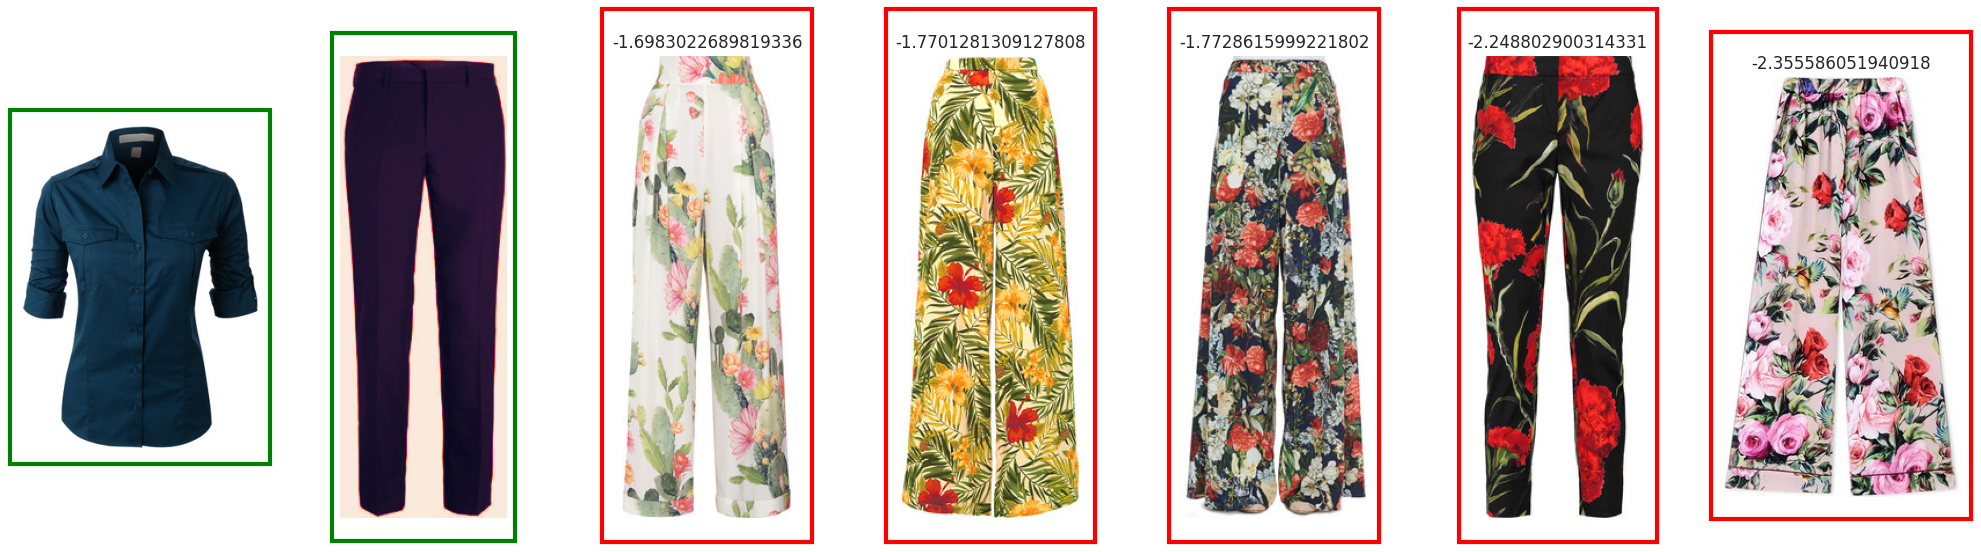

In [74]:
paths = [(query_path, None), (target_path, None)] + recommended
fig, axes = plt.subplots(1, k + 2, figsize=(k * len(recommended), 6))
for i in range(k + 2):
    img = Image.open(paths[i][0])
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(paths[i][1])

    bbox = axes[i].get_tightbbox(fig.canvas.get_renderer())
    x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
    # slightly increase the very tight bounds:
    xpad = 0.05 * width
    ypad = 0.05 * height
    color = "green" if i < 2 else "red"
    fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor=color, linewidth=3, fill=False))

plt.show()

In [58]:
import cv2
import numpy as np
from PIL import Image

def simple_overlay(person_path, garment_path, garment_mask_path=None):
    person = cv2.imread(person_path, cv2.IMREAD_UNCHANGED)
    person = cv2.cvtColor(person, cv2.COLOR_BGR2RGB)
    garment = cv2.imread(garment_path, cv2.IMREAD_UNCHANGED)  # RGBA ideally
    garment = cv2.cvtColor(garment, cv2.COLOR_BGR2RGB)
    # detect torso bbox using e.g., simple heuristic or a keypoint detector
    # here: naively center garment on upper body; for demo use fixed scale
    ph, pw = person.shape[:2]
    gh, gw = garment.shape[:2]
    scale = 0.6  # tune
    new_w = int(pw * scale)
    new_h = int(gh * new_w / gw)
    garment_resized = cv2.resize(garment, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # compute position (example: center horizontally, at 25% from top)
    x = pw//2 - new_w//2
    y = int(ph*0.2)

    # If garment has alpha channel, use it as mask
    if garment_resized.shape[2] == 4:
        alpha = garment_resized[:,:,3]/255.0
        for c in range(3):
            person[y:y+new_h, x:x+new_w, c] = (alpha * garment_resized[:,:,c] +
                                               (1-alpha) * person[y:y+new_h, x:x+new_w, c])
    else:
        # fallback: simple overlay with constant alpha
        alpha = 0.8
        person[y:y+new_h, x:x+new_w,:3] = alpha*garment_resized[:,:,:3] + (1-alpha)*person[y:y+new_h, x:x+new_w,:3]

    plt.imshow(person)
    plt.axis('off')
    plt.show()

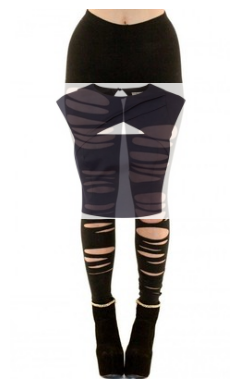

In [60]:
simple_overlay(query_path, recommended[0][0])